In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib widget

def readFile(filename):

    data = {"ch0": [], "ch1": [], "ch3": []}

    with open(filename) as file:

        # skip file header
        file.readline()
        file.readline()
        file.readline()
        file.readline()

        while True:

            # skip event header and check end of file
            if not file.readline(): break
            file.readline()

            # skip channel 0 header
            file.readline()

            ch0_vals = file.readline()
            ch0_vals = list(map(lambda x: -float(x), ch0_vals.split()))
            data["ch0"].append(np.array(ch0_vals))

            # skip channel 1 header
            file.readline()

            ch1_vals = file.readline()
            ch1_vals = list(map(lambda x: -float(x), ch1_vals.split()))
            data["ch1"].append(np.array(ch1_vals))

            # skip channel 2 header
            file.readline()

            ch3_vals = file.readline()
            ch3_vals = list(map(lambda x: -float(x), ch3_vals.split()))
            data["ch3"].append(np.array(ch3_vals))

    data["ch0"] = np.array(data["ch0"])
    data["ch1"] = np.array(data["ch1"])
    data["ch3"] = np.array(data["ch3"])

    return data

##  ################  ################  ################
##  Slow wave catcher
##  ################  ################  ################
data_slow = readFile("Data_received/New_measurements/Plate/Run_WFs_PMT+plate_100 mks_10K evts_4_1_2025_Ascii.dat")

SAMPLE_RATE_SLOW = 100
times_slow = np.arange(1024)*SAMPLE_RATE_SLOW

data_slow["times"] = times_slow
data_slow["sample_rate"] = SAMPLE_RATE_SLOW
data_slow["type"] = "slow"


##  ################  ################  ################
##  Fast wave catcher
##  ################  ################  ################
data_fast = readFile("Data_received/New_measurements/Plate/Run_WFs_PMT+plate_2.5 mks_10K evts_4_1_2025_Ascii.dat")

SAMPLE_RATE_FAST = 2.5
times_fast = np.arange(1024)*SAMPLE_RATE_FAST

data_fast["times"] = times_fast
data_fast["sample_rate"] = SAMPLE_RATE_FAST
data_fast["type"] = "fast"

In [3]:
def align_datasamples(data):

    # start index
    data["st_idx"] = np.empty(data["ch0"].shape[0], dtype=int)

    for i in range(data["ch0"].shape[0]):

        max_val = np.max(data["ch0"][i])

        start_idx = np.argmax(data["ch0"][i] >= 0.5*max_val)

        if data["type"] == "fast":
            # remove bad events. ch0 max value is about 0.8 for all good events.
            if np.max(data["ch0"][i]) < 0.6:
                start_idx = 0

        elif data["type"] == "slow":
            # sometimes we have two synchro peacks, the correct one is first and low in y scale
            # this if branch of code to account for that effect
            if start_idx > 100:
                
                start_idx = np.argmax(data["ch0"][i] >= 0.03)

        else:
            print("ERROR: unknown wave catcher type")

        data["st_idx"][i] = start_idx

    min_st_idx = int(np.min(data["st_idx"]))
    max_st_idx = int(np.max(data["st_idx"]))

    data["min_st_idx"] = min_st_idx
    data["max_st_idx"] = max_st_idx

    data_shifted = dict(data)
    data_shifted["ch0"] = np.empty([ data["ch0"].shape[0], data["ch0"].shape[1] - (max_st_idx-min_st_idx) ])
    data_shifted["ch1"] = np.empty([ data["ch1"].shape[0], data["ch1"].shape[1] - (max_st_idx-min_st_idx) ])
    data_shifted["ch3"] = np.empty([ data["ch3"].shape[0], data["ch3"].shape[1] - (max_st_idx-min_st_idx) ])


    for i in range(data["ch0"].shape[0]):

        stIdx = data["st_idx"][i]

        start_idx = stIdx-min_st_idx
        stop_ind  = data["ch0"][i].size -(max_st_idx-stIdx)

        data_shifted["ch0"][i] = data["ch0"][i, start_idx: stop_ind]
        data_shifted["ch1"][i] = data["ch1"][i, start_idx: stop_ind]
        data_shifted["ch3"][i] = data["ch3"][i, start_idx: stop_ind]

    data_shifted["times"] = data["times"][:-(max_st_idx-min_st_idx)]

    return data_shifted

data_fast_aligned = align_datasamples(data_fast)
data_slow_aligned = align_datasamples(data_slow)

EVENT_NUMBER = 0

EVENT_NUMBER = 2


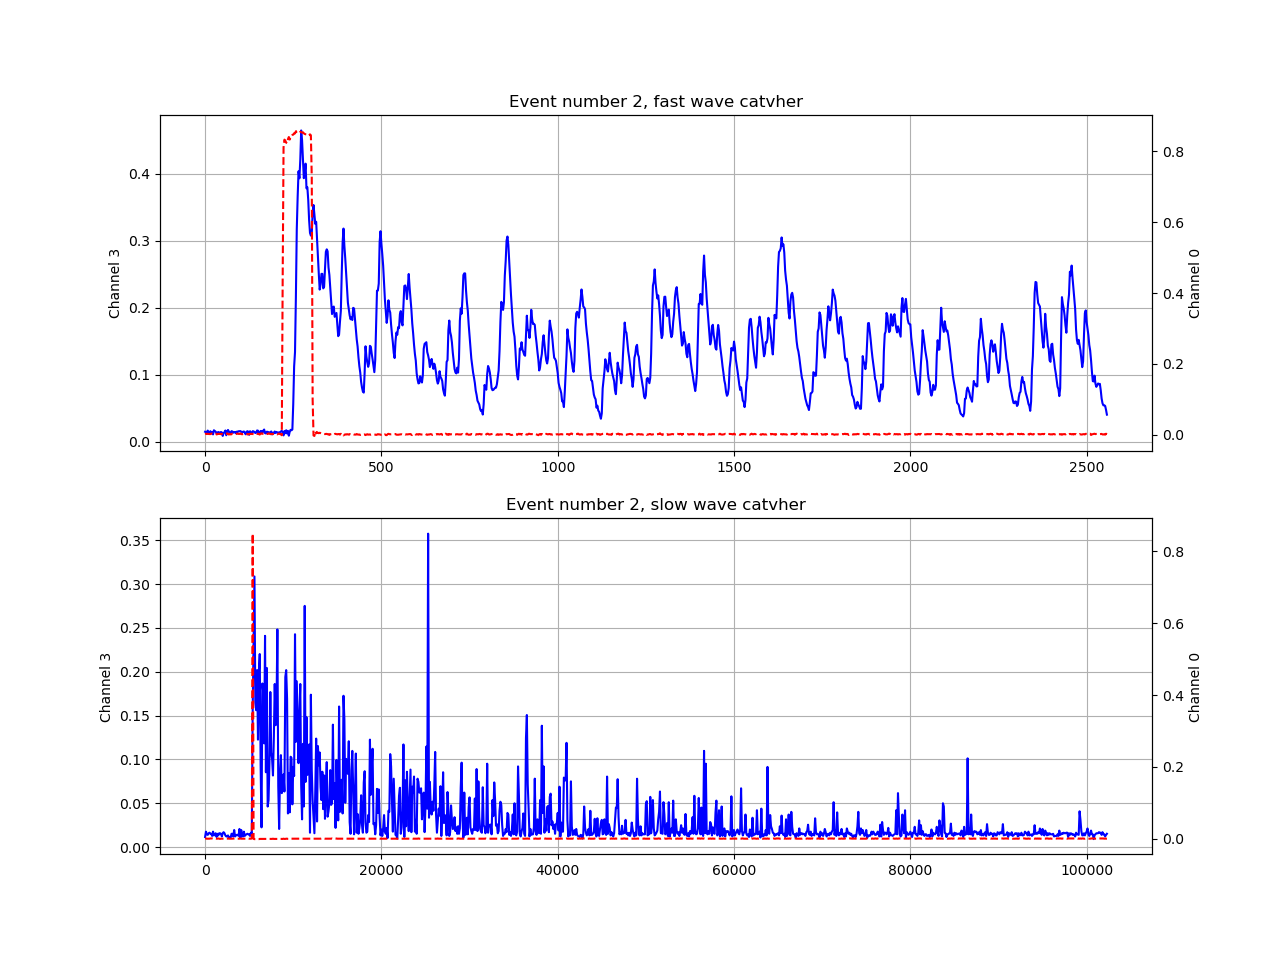

In [ ]:
EVENT_NUMBER += 1
print("EVENT_NUMBER =", EVENT_NUMBER)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(6.4*2, 4.8*2))

ax1.plot(data_fast["times"], data_fast["ch3"][EVENT_NUMBER], color="blue")
ax1.set_ylabel("Channel 3")
ax1.grid()
ax1.set_title(f"Event number {EVENT_NUMBER}, fast wave catcher")

ax1s = ax1.twinx()
ax1s.plot(data_fast["times"], data_fast["ch0"][EVENT_NUMBER], "--r")
ax1s.set_ylabel("Channel 0")



ax2.plot(data_slow["times"], data_slow["ch3"][EVENT_NUMBER], color="blue")
ax2.set_ylabel("Channel 3")
ax2.grid()
ax2.set_title(f"Event number {EVENT_NUMBER}, slow wave catcher")

ax2s = ax2.twinx()
ax2s.plot(data_slow["times"], data_slow["ch0"][EVENT_NUMBER], "--r")
ax2s.set_ylabel("Channel 0");


In [5]:
# def visualise_aligning(data_raw, data_aligned):

#     plt.figure(figsize=(6.4*2, 4.8*2))

#     assert data_raw["type"] == data_aligned["type"]


#     plt.subplot(3,1,1)
#     plt.plot(data_raw["times"], np.mean(data_raw["ch0"], axis=0), label="not aligned")
#     plt.plot(data_aligned["times"], np.mean(data_aligned["ch0"], axis=0), label="aligned")
#     plt.title(f"ch0, {data_raw['type']} wavecatcher")
#     plt.legend()
#     plt.grid()
#     plt.ylabel("Averaged readings")

#     plt.subplot(3,1,2)
#     plt.plot(data_raw["times"], np.mean(data_raw["ch1"], axis=0), label="not aligned")
#     plt.plot(data_aligned["times"], np.mean(data_aligned["ch1"], axis=0), label="aligned")
#     plt.title("ch1")
#     plt.legend()
#     plt.grid()
#     plt.ylabel("Averaged readings")

#     plt.subplot(3,1,3)
#     plt.plot(data_raw["times"], np.mean(data_raw["ch3"], axis=0), label="not aligned")
#     plt.plot(data_aligned["times"], np.mean(data_aligned["ch3"], axis=0), label="aligned")
#     plt.title("ch3")
#     plt.legend()
#     plt.grid()
#     plt.ylabel("Averaged readings")

#     plt.xlabel("time [ns]")



# visualise_aligning(data_slow, data_slow_aligned)
# visualise_aligning(data_fast, data_fast_aligned)